In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import os


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus=torch.cuda.device_count()
print(f"Found {num_gpus} GPUs.Training starting")


transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]) ])


base_path='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir=os.path.join(base_path,'train')
valid_dir=os.path.join(base_path,'valid')
train_data=datasets.ImageFolder(train_dir,transform=transform)
valid_data=datasets.ImageFolder(valid_dir,transform=transform)


train_loader = DataLoader(train_data,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)
valid_loader = DataLoader(valid_data,batch_size=64,shuffle=False,num_workers=4,pin_memory=True)


model=timm.create_model('vit_tiny_patch16_224',pretrained=True,num_classes=len(train_data.classes))

#MultiGPU Parallelism
if num_gpus>1:
    model=nn.DataParallel(model)
model=model.to(device)

criterion =nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)

print("Starting Training")
for epoch in range(3):
    model.train()
    running_loss=0.0
    for images,labels in train_loader:
        images,labels=images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    print(f"Epoch {epoch+1}/3|Loss:{running_loss/len(train_loader):.4f}")


print("Generating Final Results")
model.eval()
all_preds,all_labels =[],[]
with torch.no_grad():
    for images,labels in valid_loader:
        images,labels=images.to(device),labels.to(device)
        outputs=model(images)
        _,preds=torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Found 2 GPUs.Training starting


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Starting Training
Epoch 1/3|Loss:0.1443
Epoch 2/3|Loss:0.0224
Epoch 3/3|Loss:0.0172
Generating Final Results


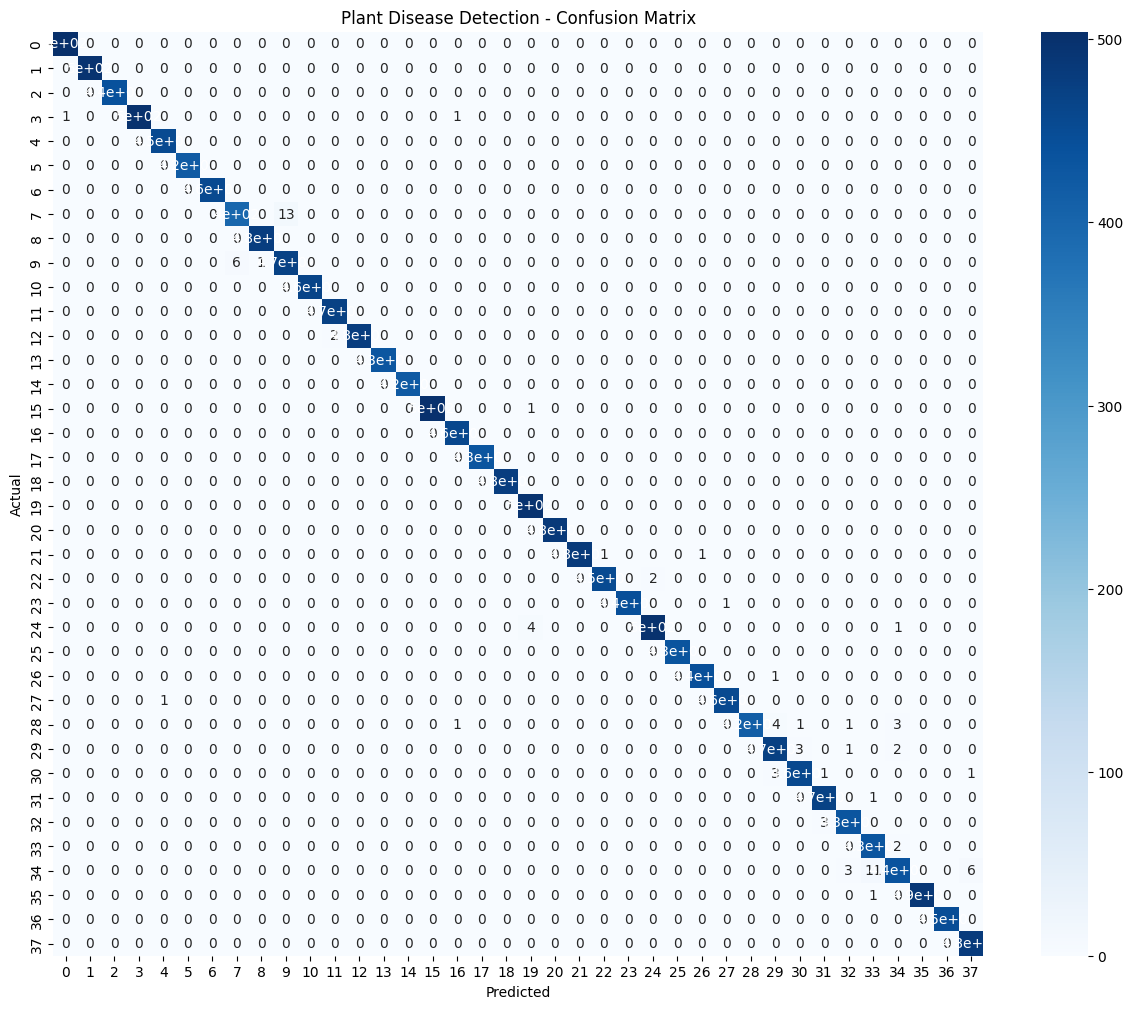


Final Accuracy Report saved as final_accuracy_report.txt
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       1.00      1.00      1.00       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.99      0.97      0.98       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(

In [3]:
plt.figure(figsize=(15,12))
cm = confusion_matrix(all_labels,all_preds)
sns.heatmap(cm, annot=True,cmap='Blues')
plt.title("Plant Disease Detection - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('final_confusion_matrix.png',dpi=300) 
plt.show()

report = classification_report(all_labels,all_preds,target_names=train_data.classes)
with open("final_accuracy_report.txt","w") as f:
    f.write(report)

print("\nFinal Accuracy Report saved as final_accuracy_report.txt")
print(report)

save_obj = model.module.state_dict() if isinstance(model,nn.DataParallel) else model.state_dict()
torch.save(save_obj,'new_plant_diseases.pth')
print("Model saved to /kaggle/working/new_plant_diseases.pth")